In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import expipe
import pathlib
import numpy as np
import spatial_maps.stats as stats
import septum_mec.analysis.data_processing as dp
from septum_mec.analysis.registration import store_notebook
import head_direction.head as head
import spatial_maps as sp
import pnnmec.registration
import speed_cells.speed as spd
import re
import joblib
import multiprocessing
import shutil
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import pnnmec
import scipy.ndimage.measurements
import quantities as pq
import exdir
from tqdm import tqdm_notebook as tqdm
from septum_mec.analysis.trackunitmulticomparison import TrackMultipleSessions
import networkx as nx
from nxpd import draw
%matplotlib inline

10:36:09 [I] klustakwik KlustaKwik2 version 0.2.6


In [3]:
project_path = dp.project_path()

project = expipe.get_project(project_path)
actions = project.actions

In [4]:
identify_neurons = project.require_action('identify-neurons')

In [5]:
actions['1833-010719-2'].attributes

{'users': ['Mikkel Lepperød'],
 'tags': ['11hz', 'stim-ms', 'stim i', 'septum', 'open-ephys'],
 'datetime': '2019-07-01T12:54:49',
 'type': 'Recording',
 'registered': '2019-07-02T14:53:28',
 'data': {'main': 'main.exdir'},
 'location': 'IMB',
 'entities': ['1833']}

In [6]:
data_loader = dp.Data()

In [7]:
sessions = []
for action in actions.values():
    if action.type != 'Recording':
        continue
    action_data_path = pathlib.Path(action.data_path('main'))
    processing = exdir.File(action_data_path)['processing']
    if not 'electrophysiology' in processing:
        continue
    elphys = processing['electrophysiology']
    if 'spikesorting' not in elphys:
        continue
    tags = [t.lower() for t in action.tags]
    
    freq = np.nan
    stimulated = False
    baseline = False
    is_i = False
    is_ii = False
    tag = None
    stim_location = None
    
    stim_times = data_loader.stim_times(action.id)
    if stim_times is not None:
        stimulated = True
        freq = round(1 / np.median(np.diff(stim_times)))
        
    
    
    tag_i = [i for i, t in enumerate(tags) if 'baseline ' in t or 'stim ' in t]
    if len(tag_i) == 1:
        tag = tags[tag_i[0]]
        what, how = tag.split(' ')
        if what == 'stim':
            where = [t for t in tags if 'stim-' in t]
            assert len(where) == 1
            stim_location = where[0].split('-')[-1]
            assert stimulated
        elif what == 'baseline':
            baseline = True
            assert not stimulated
        else:
            raise Exception(f'Found {tag}, what to do?')
        if how == 'i':
            is_i = True
        elif how == 'ii':
            is_ii = True
        else:
            raise Exception(f'Found {tag}, what to do?')
    elif len(tag_i) > 1:
        print(action.id, [tags[i] for i in tag_i])
        
    

    sessions.append({
        'tag': tag,
        'action': action.id,
        'stimulated': stimulated,
        'baseline': baseline,
        'i': is_i,
        'ii': is_ii,
        'frequency': float(freq),
        'session': int(action.id.split('-')[-1]),
        'stim_location': stim_location,
        'entity': int(action.entities[0]),

    })
sessions = pd.DataFrame(sessions)

/home/mikkel/.virtualenvs/expipe/lib/python3.6/site-packages/quantities/quantity.py:386: RuntimeWarning: invalid value encountered in less_equal
  return self.magnitude <= other


In [9]:
sessions.query('i and ii')

,action,baseline,entity,frequency,i,ii,session,stim_location,stimulated,tag


# Identify unique neurons

In [304]:
output = pathlib.Path('output/identify_neurons')

max_dissimilarity = .035
for entity in sessions.entity.unique():
    unit_matching = TrackMultipleSessions(
        actions, list(sessions.query(f'entity=={entity}').action), 
        progress_bar=tqdm, verbose=False, data_path=output / f'{entity}-graphs'
    )
    unit_matching.do_matching()
    unit_matching.make_graphs_from_matches()
    # save graph with all dissimilarities for later use
    unit_matching.save_graphs()
    # cutoff large dissimilarities
    unit_matching.threshold_dissimilarity(max_dissimilarity)
    unit_matching.remove_edges_with_duplicate_actions()
    unit_matching.identify_units()
    units = []
    for ch, group in unit_matching.identified_units.items():
        for unit_id, val in group.items():
            for action_id, orig_unit_ids in val['original_unit_ids'].items():
                units.extend([
                    {
                        'unit_name': name, 
                        'unit_id': unit_id, 
                        'action_id': action_id,
                        'channel_group': ch,
                        'max_dissimilarity': max_dissimilarity
                    } 
                    for name in orig_unit_ids])

    pd.DataFrame(units).to_csv(output / f'{entity}-units.csv', index=False)

In [282]:
sessions.to_csv(output / 'sessions.csv', index=False)

In [283]:
unique_units = pd.concat([
    pd.read_csv(p) 
    for p in output.iterdir() 
    if p.name.endswith('units.csv')])

In [284]:
unique_units.to_csv(output / 'unique_units.csv', index=False)

# yoyoyo

In [288]:
unit_comp = TrackMultipleSessions(actions, data_path=f'output/identify_neurons_weighted/1833-graphs')

In [299]:
unit_comp.load_graphs()

In [300]:
# unit_comp._compute_timedelta()
# unit_comp.save_graphs()

In [301]:
unit_comp.threshold_dissimilarity(0.08)

In [302]:
# unit_comp.threshold_timedelta(timedelta(days=10))

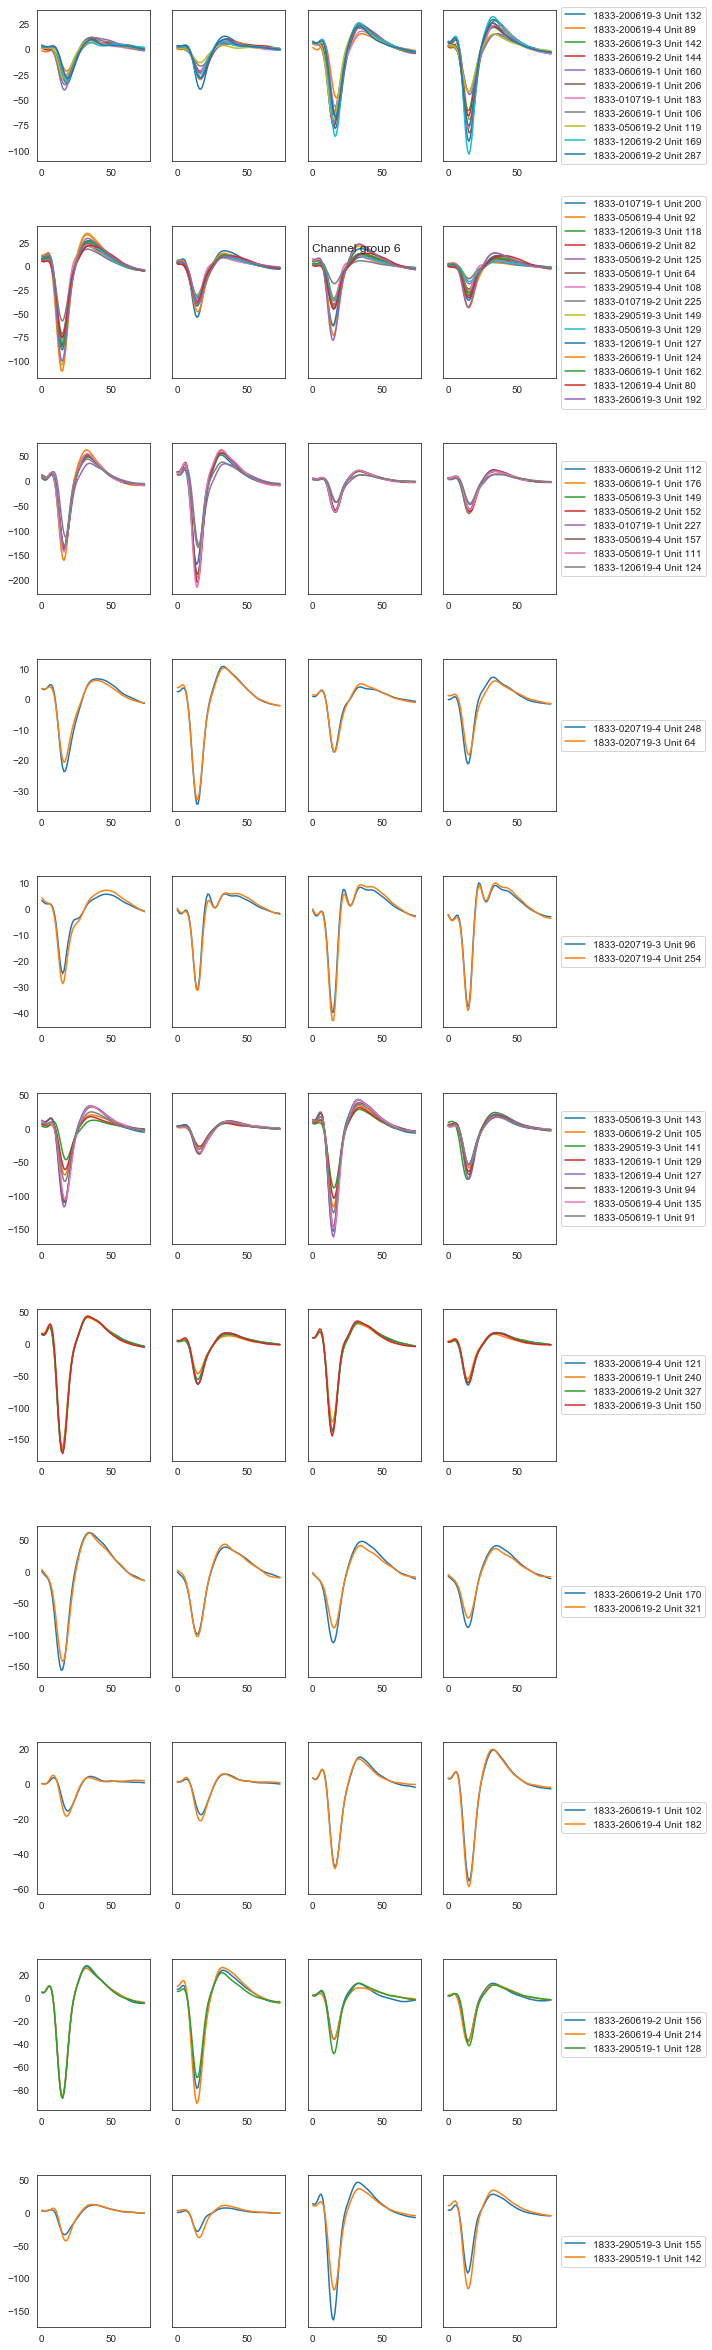

In [303]:
unit_comp.remove_edges_with_duplicate_actions()
unit_comp.identify_units()
unit_comp.plot_matches('template', chan_group=6, step_color=False)
plt.tight_layout()

In [298]:
[d['weight'] for _,_, d in unit_comp.graphs[6].edges(data=True)]

[0.09634455200883546,
 0.07499588360280243,
 0.06162436970571908,
 0.06857233657530502,
 0.09694714236387678,
 0.0804227088795645,
 0.08824651636929137,
 0.08722175061166056,
 0.09845396075578684,
 0.09294308631598447,
 0.09659570944622126,
 0.07647245393573131,
 0.09195911715516754,
 0.0833125753315933,
 0.051087130456977776,
 0.049521116821066226,
 0.02600808417111924,
 0.0320818045314623,
 0.03229996342323004,
 0.029418636630051426,
 0.04647284442507242,
 0.087113075493381,
 0.05515341343597296,
 0.05825520656684215,
 0.0707770976250612,
 0.04259170631553064,
 0.04251915445433371,
 0.08660506600667285,
 0.060867941039334024,
 0.09247442840294415,
 0.05688725030444264,
 0.02585312905314643,
 0.02256877562004955,
 0.03841936694076317,
 0.050287440931407607,
 0.08012546713128958,
 0.015016185438421958,
 0.039239181359156536,
 0.04873498182486496,
 0.07384202529475573,
 0.031544066489664284,
 0.038465046537750666,
 0.038985147903295735,
 0.045067437101008266,
 0.07420871091322713,
 0.01

In [87]:
cmp = TrackMultipleSessions(actions)

In [95]:
from septum_mec.analysis.track_units_tools import plot_waveform, dissimilarity, dissimilarity_weighted

In [90]:
from matplotlib import gridspec

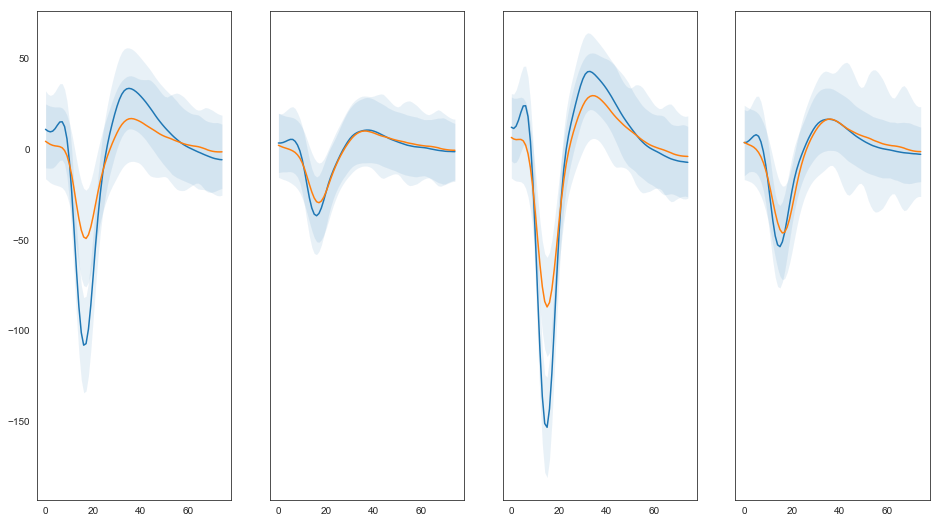

In [230]:
fig = plt.figure(figsize=(16, 9))
gs = gridspec.GridSpec(1, 1)

wf1 = cmp.load_waveforms('1833-050619-3', 143, 6)
wf2 = cmp.load_waveforms('1833-200619-3', 126, 6)
axs = plot_waveform(wf1, fig, gs[0])
plot_waveform(wf2, fig, gs[0], axs=axs)

In [276]:
d00 = dissimilarity(wf1.mean(), wf2.mean())
d00

0.24673824079040996

In [275]:
d10 = dissimilarity_weighted(wf1, wf2)
d10

0.12165202171836166

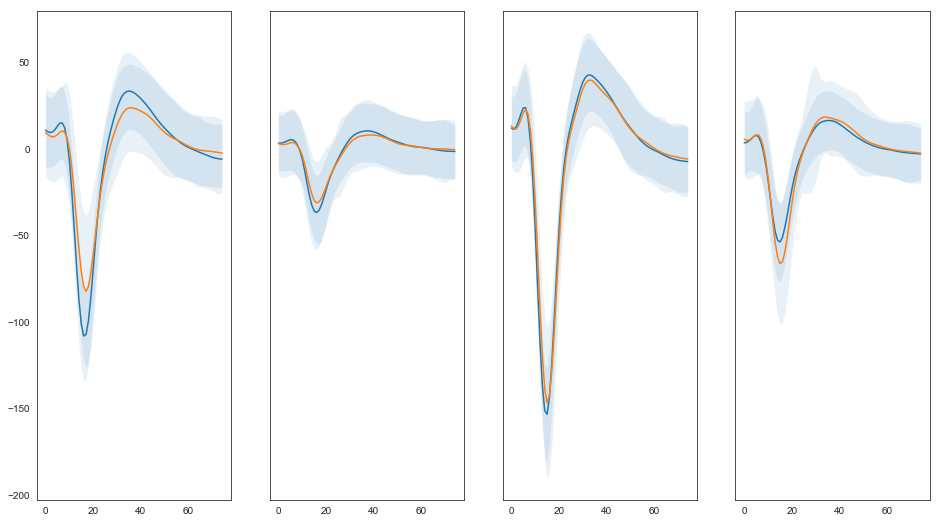

In [233]:
fig = plt.figure(figsize=(16, 9))
gs = gridspec.GridSpec(1, 1)

wf3 = cmp.load_waveforms('1833-050619-3', 143, 6)
wf4 = cmp.load_waveforms('1833-060619-1', 170, 6)
axs = plot_waveform(wf3, fig, gs[0])
plot_waveform(wf4, fig, gs[0], axs=axs)

In [278]:
d01 = dissimilarity(wf3.mean(), wf4.mean())
d01

0.04522270245629878

In [277]:
d11 = dissimilarity_weighted(wf3, wf4)
d11

0.05528103485716783

In [236]:
d00 / d01

5.45607023438829

In [237]:
d10 / d11

1.1824085223080825

In [239]:
t = abs(actions['1833-260619-2'].datetime - actions['1833-050619-3'].datetime)

In [240]:
t > timedelta(15)

True

# Store results in Expipe action

In [64]:
identify_neurons.data['sessions'] = 'sessions.csv'
identify_neurons.data['units'] = 'units.csv'

In [321]:
sessions.to_csv(identify_neurons.data_path('sessions'), index=False)
# units.to_csv(identify_neurons.data_path('units'), index=False)

In [318]:
store_notebook(
    identify_neurons, "00-identify-neurons.ipynb")